# ARIMA Models For Sales Prediction in Kalbe Nutritionals

## Loading library and datasets 

In [1]:
# importing necessary library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import statsmodels.tsa.stattools as st
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import warnings
warnings.filterwarnings('ignore')
import pmdarima as pm
from tabulate import tabulate

In [2]:
# read dataset
df_customer = pd.read_csv('Case Study - Customer.csv', delimiter = ';')
df_product = pd.read_csv('Case Study - Product.csv', delimiter =';')
df_store = pd.read_csv('Case Study - Store.csv', delimiter =';')
df_transaction = pd.read_csv('Case Study - Transaction.csv', delimiter=';')

In [3]:
df_customer.shape, df_product.shape, df_store.shape, df_transaction.shape

((447, 5), (10, 3), (14, 6), (5020, 8))

In [4]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,"5,12"
1,2,60,1,Married,"6,23"
2,3,32,1,Married,"9,17"
3,4,31,1,Married,"4,87"
4,5,58,1,Married,"3,57"


In [5]:
df_product.head()

,ProductID,Product Name,Price
0,P1,Choco Bar,8800
1,P2,Ginger Candy,3200
2,P3,Crackers,7500
3,P4,Potato Chip,12000
4,P5,Thai Tea,4200


In [6]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,"-6,2","106,816666"
1,2,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"
2,3,Prima Kota,Prima,Modern Trade,"-7,797068","110,370529"
3,4,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
4,5,Bonafid,Gita,General Trade,"-7,250445","112,768845"


In [7]:
df_transaction.head()

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID
0,TR11369,328,01/01/2022,P3,7500,4,30000,12
1,TR16356,165,01/01/2022,P9,10000,7,70000,1
2,TR1984,183,01/01/2022,P1,8800,4,35200,4
3,TR35256,160,01/01/2022,P1,8800,7,61600,4
4,TR41231,386,01/01/2022,P9,10000,1,10000,4


## Data Cleaning & Preparation

In [8]:
#data cleaning df_customer
df_customer['Income'] = df_customer['Income'].replace(',','.', regex = True).astype('float')

In [9]:
df_customer.head()

,CustomerID,Age,Gender,Marital Status,Income
0,1,55,1,Married,5.12
1,2,60,1,Married,6.23
2,3,32,1,Married,9.17
3,4,31,1,Married,4.87
4,5,58,1,Married,3.57


In [10]:
df_customer.duplicated().sum()

0

In [11]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    3
Income            0
dtype: int64

In [12]:
df_customer = df_customer.dropna()

In [13]:
df_customer.isnull().sum()

CustomerID        0
Age               0
Gender            0
Marital Status    0
Income            0
dtype: int64

In [14]:
#data cleaning df_store
df_store['Latitude'] = df_store['Latitude'].replace(',','.', regex = True).astype('float')
df_store['Longitude'] = df_store['Latitude'].replace(',','.', regex = True).astype('float')

In [15]:
df_store.head()

,StoreID,StoreName,GroupStore,Type,Latitude,Longitude
0,1,Prima Tendean,Prima,Modern Trade,-6.200000,-6.200000
1,2,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,-6.914864
2,3,Prima Kota,Prima,Modern Trade,-7.797068,-7.797068
3,4,Gita Ginara,Gita,General Trade,-6.966667,-6.966667
4,5,Bonafid,Gita,General Trade,-7.250445,-7.250445


In [16]:
df_store.duplicated().sum()

0

In [17]:
df_store.isnull().sum()

StoreID       0
StoreName     0
GroupStore    0
Type          0
Latitude      0
Longitude     0
dtype: int64

In [18]:
#data cleaning df_product
df_product.duplicated().sum()

0

In [19]:
df_product.isnull().sum()

ProductID       0
Product Name    0
Price           0
dtype: int64

In [20]:
#data cleaning df_transaction
df_transaction.duplicated().sum()

0

In [21]:
df_transaction.isnull().sum()

TransactionID    0
CustomerID       0
Date             0
ProductID        0
Price            0
Qty              0
TotalAmount      0
StoreID          0
dtype: int64

In [22]:
df_transaction.dtypes

TransactionID    object
CustomerID        int64
Date             object
ProductID        object
Price             int64
Qty               int64
TotalAmount       int64
StoreID           int64
dtype: object

In [23]:
df_transaction['Date'] = pd.to_datetime(df_transaction['Date'])

In [24]:
df_transaction.dtypes

TransactionID            object
CustomerID                int64
Date             datetime64[ns]
ProductID                object
Price                     int64
Qty                       int64
TotalAmount               int64
StoreID                   int64
dtype: object

In [25]:
# merge all table into one
df_merge = pd.merge(df_customer, df_transaction, on = ['CustomerID'])
df_merge = pd.merge(df_merge, df_store, on = ['StoreID'])
df_merge = pd.merge(df_merge, df_product.drop(columns = ['Price']), on = ['ProductID'])
df_merge = df_merge.sort_values(by='Date').reset_index(drop = True)
df_merge.head()

,CustomerID,Age,Gender,Marital Status,Income,TransactionID,Date,ProductID,Price,Qty,TotalAmount,StoreID,StoreName,GroupStore,Type,Latitude,Longitude,Product Name
0,183,27,1,Single,0.18,TR1984,2022-01-01,P1,8800,4,35200,4,Gita Ginara,Gita,General Trade,-6.966667,-6.966667,Choco Bar
1,49,44,1,Married,13.48,TR67455,2022-01-01,P5,4200,3,12600,13,Buana,Buana,General Trade,-1.269160,-1.269160,Thai Tea
2,233,43,1,Married,5.69,TR97336,2022-01-01,P7,9400,2,18800,12,Prestasi Utama,Prestasi,General Trade,-2.990934,-2.990934,Coffee Candy
3,287,36,0,Single,3.70,TR76340,2022-01-01,P4,12000,4,48000,12,Prestasi Utama,Prestasi,General Trade,-2.990934,-2.990934,Potato Chip
4,123,34,0,Married,4.36,TR99839,2022-01-01,P2,3200,6,19200,1,Prima Tendean,Prima,Modern Trade,-6.200000,-6.200000,Ginger Candy


In [26]:
# rename all columns into lowercase and drop irrelevant column
for column in df_merge.columns:
    df_merge.rename(columns = {column:column.lower()}, inplace = True)
df_merge.rename(columns= {'marital status':'marital_status'}, inplace = True)
df_merge.rename(columns = {'product name':'product_name'}, inplace = True)
df_merge = df_merge.drop(['latitude','longitude'], axis=1)
df_merge['date'] =pd.to_datetime(df_merge['date'], format ='%d%m%Y', infer_datetime_format=True)
df_merge.head()

,customerid,age,gender,marital_status,income,transactionid,date,productid,price,qty,totalamount,storeid,storename,groupstore,type,product_name
0,183,27,1,Single,0.18,TR1984,2022-01-01,P1,8800,4,35200,4,Gita Ginara,Gita,General Trade,Choco Bar
1,49,44,1,Married,13.48,TR67455,2022-01-01,P5,4200,3,12600,13,Buana,Buana,General Trade,Thai Tea
2,233,43,1,Married,5.69,TR97336,2022-01-01,P7,9400,2,18800,12,Prestasi Utama,Prestasi,General Trade,Coffee Candy
3,287,36,0,Single,3.70,TR76340,2022-01-01,P4,12000,4,48000,12,Prestasi Utama,Prestasi,General Trade,Potato Chip
4,123,34,0,Married,4.36,TR99839,2022-01-01,P2,3200,6,19200,1,Prima Tendean,Prima,Modern Trade,Ginger Candy


## Forecasting Dataframe

In [27]:
# make new dataframe
df_regression = df_merge.groupby(['date']).agg({'qty': 'sum'}).reset_index()
df_regression 

,date,qty
0,2022-01-01,49
1,2022-01-02,50
2,2022-01-03,76
3,2022-01-04,98
4,2022-01-05,67
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,40


<Axes: xlabel='date', ylabel='qty'>

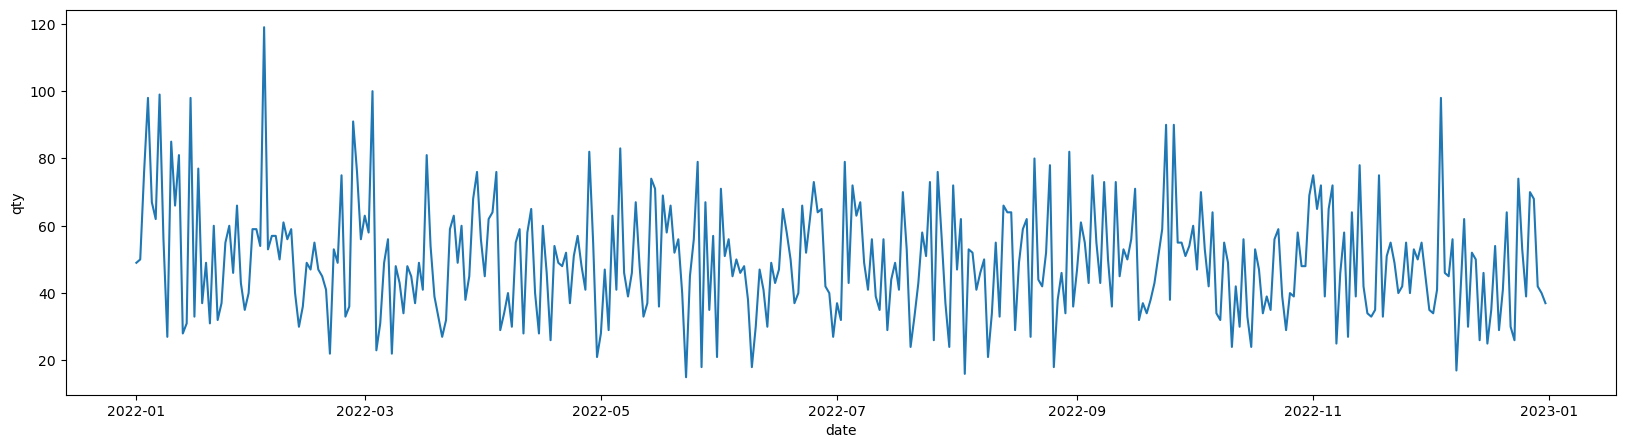

In [28]:
# plot the quantity based on data
plt.figure(figsize=(20,5))
sns.lineplot(data=df_regression , x=df_regression['date'] , y=df_regression['qty'])

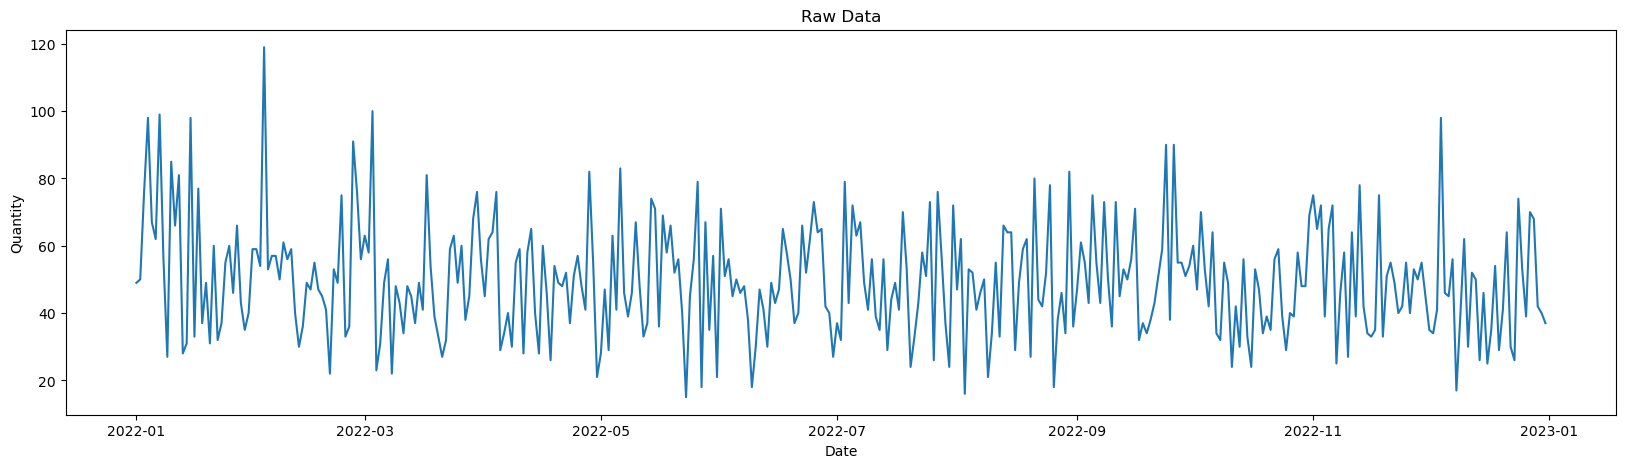

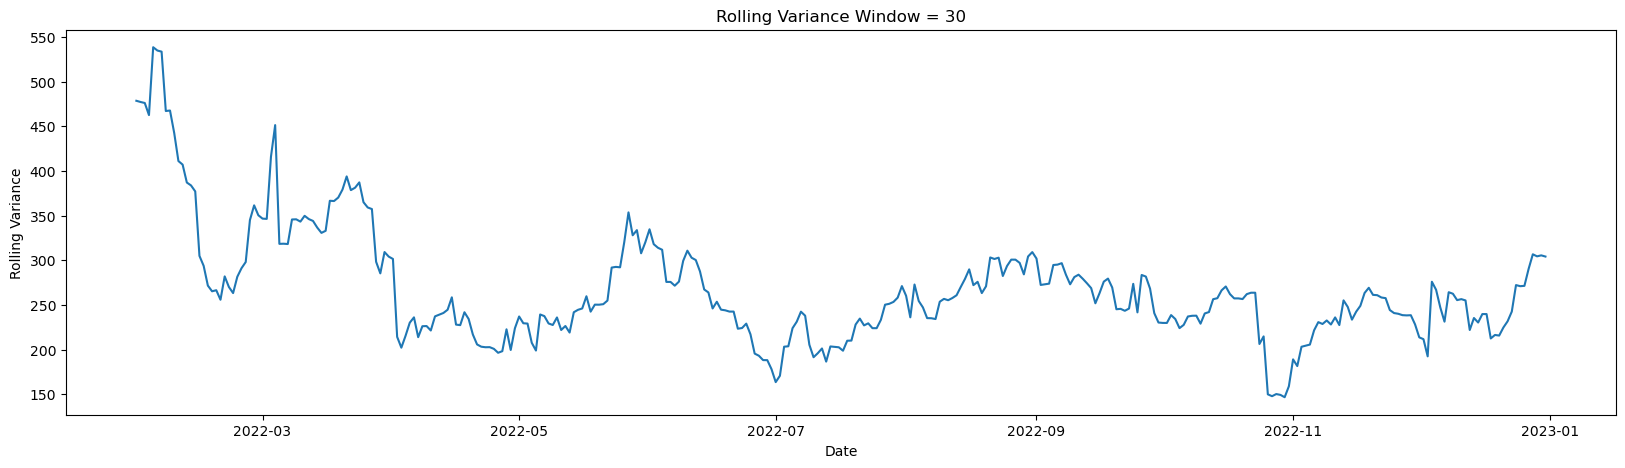

In [29]:
# plot the raw data
plt.figure(figsize=(20, 5))
plt.plot(df_regression['date'], df_regression['qty'])
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Raw Data')

# compute rolling variance and plot
window = 30
rolling_var = df_regression['qty'].rolling(window = window).var()
plt.figure(figsize=(20,5))
plt.plot(df_regression['date'],rolling_var)
plt.xlabel('Date')
plt.ylabel('Rolling Variance')
plt.title(f'Rolling Variance Window = {window}')
plt.show()

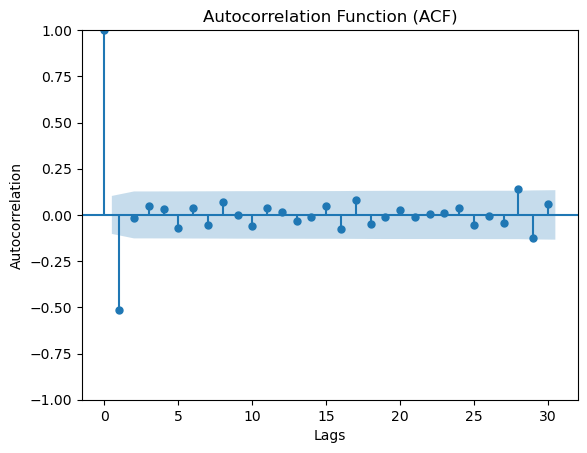

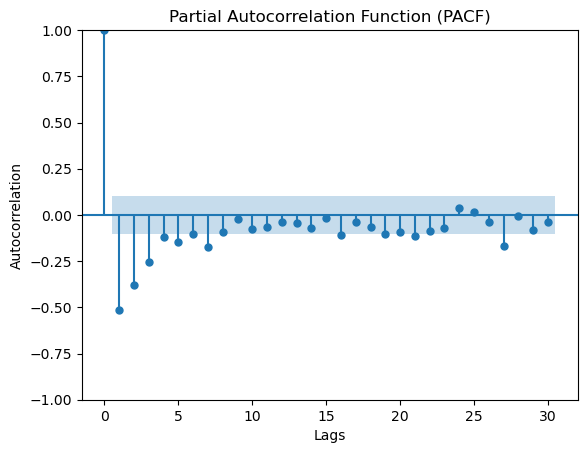

In [32]:
# plot ACF using default
plot_acf(df_regression['qty'].diff().dropna(), lags=30)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

#plot PACF using ywm method
plot_pacf(df_regression['qty'].diff().dropna(), lags=30, method='ywm')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

The ACF graph shows that p order = 2, because the first and second lag is significantly out of the limit.
The PACF graph shows that q order = 3, because there is significantly correlation of the first until third lags.

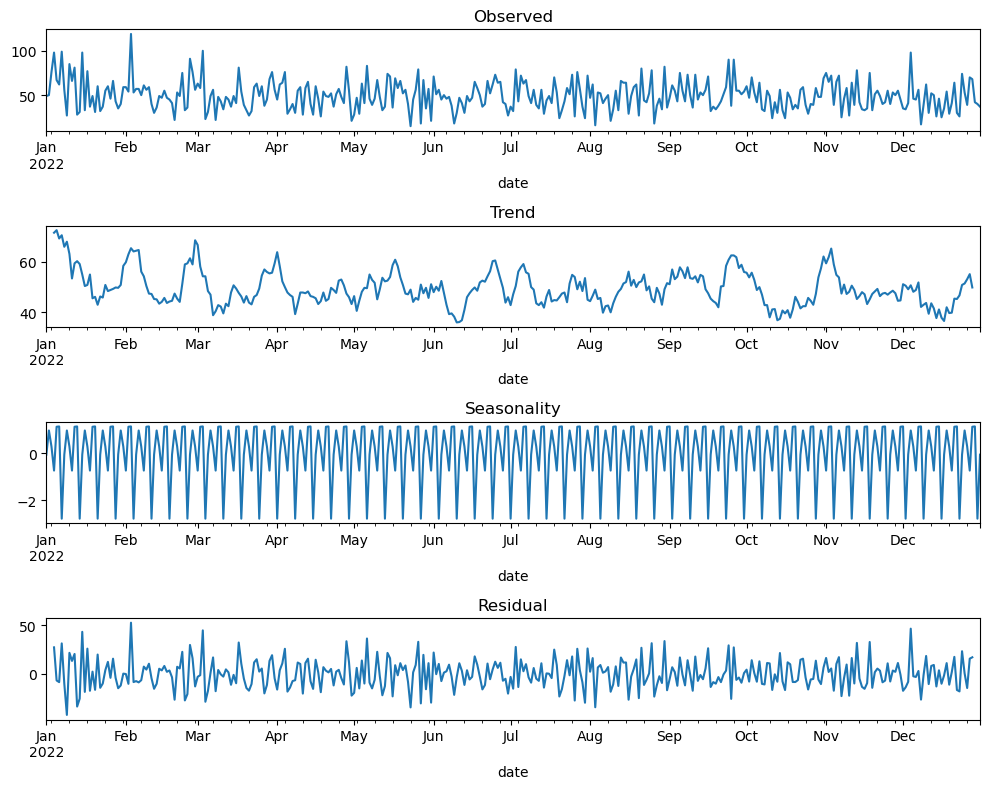

In [33]:
# split time series into 3 components : trend, seasonality, and residuals
reg_decompose = seasonal_decompose(df_regression.set_index('date'))
plt.figure(figsize = (10,8))

plt.subplot(411)
reg_decompose.observed.plot(ax = plt.gca())
plt.title('Observed')

plt.subplot(412)
reg_decompose.trend.plot(ax = plt.gca())
plt.title('Trend')

plt.subplot(413)
reg_decompose.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')

plt.subplot(414)
reg_decompose.resid.plot(ax = plt.gca())
plt.title('Residual')

plt.tight_layout()

In [34]:
#Augmented Dickey-Fuller (ADF) Test 
df_test = adfuller(df_regression['qty'], autolag='AIC')
df_test

(-19.09151387240814,
 0.0,
 0,
 364,
 {'1%': -3.4484434475193777,
  '5%': -2.869513170510808,
  '10%': -2.571017574266393},
 2911.2984266302406)

In [35]:
# Check if the data stationary or not
def adf_test(dataset):
    df_test = adfuller(dataset, autolag ='AIC')
    print("1. ADF = ", df_test[0])
    print("2. p-value = ", df_test[1])
    print("3. Num of lags= ", df_test[2])
    print("4. Num of observation used for ADF regression= ", df_test[3])
    print("5. Critical Values= ")
    for key,value in df_test[4].items():
        print(f'\t {key} : {value}')
adf_test(df_regression['qty'])

1. ADF =  -19.09151387240814
2. p-value =  0.0
3. Num of lags=  0
4. Num of observation used for ADF regression=  364
5. Critical Values= 
	 1% : -3.4484434475193777
	 5% : -2.869513170510808
	 10% : -2.571017574266393


Based on ADF test, we've got ADF < Critical Values, and p-value < 0.05. Then we can conclude the data is stationary, and can be used in time series analysis with ARIMA

## Find p,d,q for ARIMA Model Predictions

In [36]:
# change to 1 column(qty)
df_regression2 = df_merge.groupby(['date']).agg({'qty': 'sum'})
df_regression2.shape
df_regression2

,qty
date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


In [37]:
# Split data train & data test
split_size = round(df_regression2.shape[0] * 0.8)

data_train = df_regression2[:split_size]
data_test = df_regression2[split_size:]
data_train.shape , data_test.shape

((292, 1), (73, 1))

In [38]:
data_train.head()

,qty
date,
2022-01-01,49
2022-01-02,50
2022-01-03,76
2022-01-04,98
2022-01-05,67


In [39]:
data_test.head()

,qty
date,
2022-10-20,39
2022-10-21,35
2022-10-22,56
2022-10-23,59
2022-10-24,39


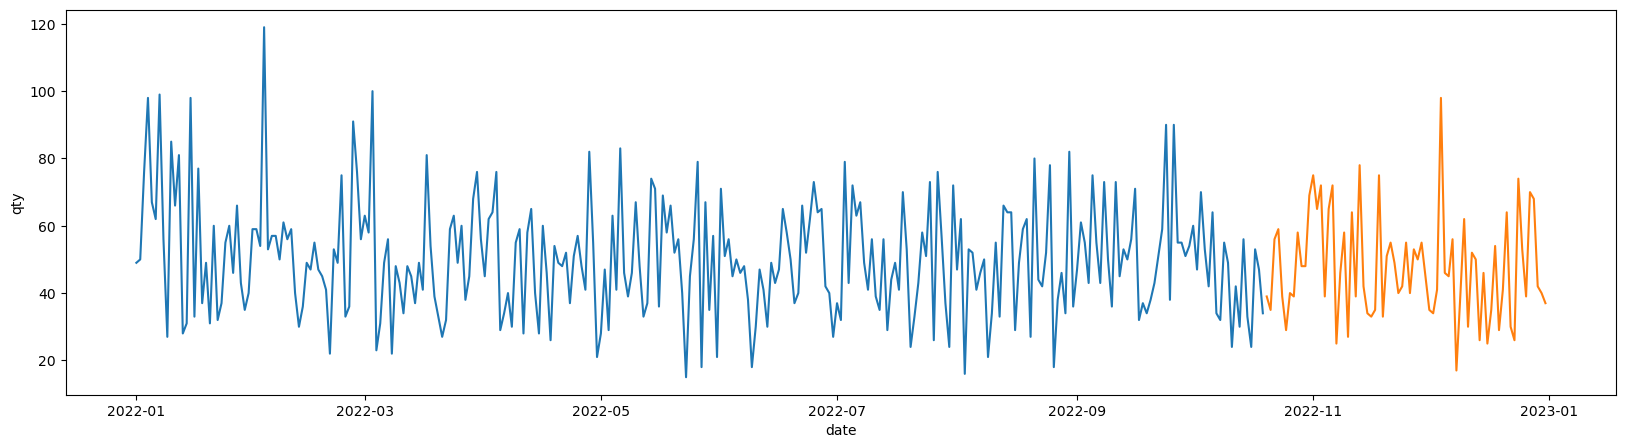

In [40]:
#plot data train and data test
plt.figure(figsize=(20,5))
sns.lineplot(data=data_train , x=data_train.index , y=data_train['qty'])
sns.lineplot(data=data_test, x=data_test.index, y=data_test['qty'])
plt.show()

### Model 1: Auto-fit ARIMA

In [41]:
auto_arima = pm.auto_arima(data_train, trace=True, seasonal=False, stepwise=False, suppress_warnings=True)
auto_arima.summary()

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3148.880, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2958.985, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2854.559, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2806.846, Time=0.30 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2742.365, Time=0.42 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2720.255, Time=0.59 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2675.327, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2495.886, Time=0.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2497.851, Time=0.45 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2499.545, Time=0.94 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2500.500, Time=1.00 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2595.516, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2497.848, Time=0.52 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2498.709, Time=0.60 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2500.705, Time=0.90 sec
 ARIMA(3,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1244.943
Date:                Mon, 23 Oct 2023   AIC                           2495.886
Time:                        06:09:33   BIC                           2506.916
Sample:                    01-01-2022   HQIC                          2500.304
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    4.8e-05   2.08e+04      0.000       1.000       1.000
ma.L1         -0.9830      0.016    -60.722      0.000      -1.015      -0.951
sigma2       290.0520     24.022     12.074      0.000     242.969     337.135
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 8.00
Prob(Q):                              0.74   Prob(JB):                         0.02
Heteroskedasticity (H):               0.70   Skew:                             0.39
Prob(H) (two-sided):                  0.08   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1. ARIMA model combine 2 models(Auto Regression [AR] + Moving Average [MA]) & 1 method(Differencing [I]).
2. We can call ARIMA model if we apply differencing [I] at least once to make the data stationary and combine AR and MA to make forecasting based on old time-series data.
3. We can assume that in ARIMA :  
 - p = AR = The number of Autoregressive terms
 - d = I = The number of nonseasonal differences
 - q = MA = The number of lagged forecast errors in the prediction equation
 4. ARIMA(1,0,1) means that there are no differencing (0) because it is stationary, and we are performing autoregression on the series with 1 lag and 1 moving average order is applied.

### Model 2 : ACF & PACF Plot

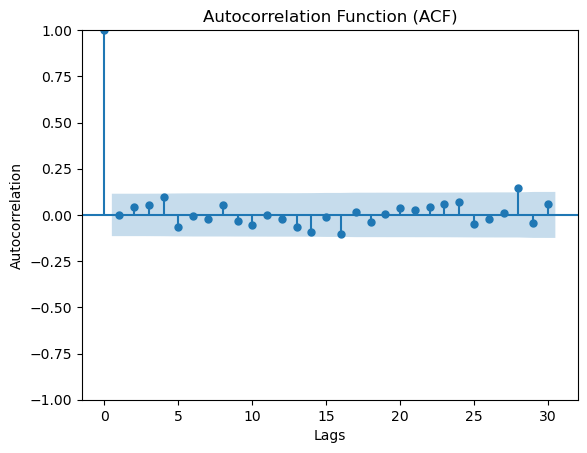

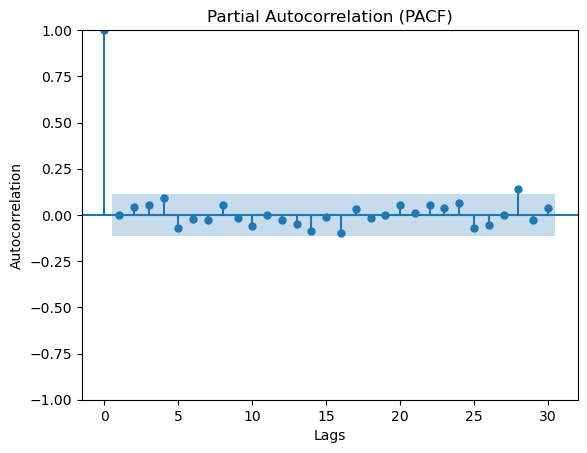

In [42]:
plot_acf(data_train, lags=30)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')


plot_pacf(data_train, lags=30)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Partial Autocorrelation (PACF)')
plt.show()

Tail off at pattern ACF --> AR Model --> Cut off at PACF will provide order p for AR(p)
Tail off pattern ACF that is out from Threshold levels is 28th lag.

Tail off at pattern PACF --> MA Model --> Cut off at ACF will provide order q for MA(q)
Tail off pattern PACF that is out from Threshold levels is 28th lag.

Tail of at both ACF and PACF --> ARMA model

Conclusion :
p,d,q = 28,0,28

### Model 3 : Autocorrelation Plot

(0.0, 100.0)

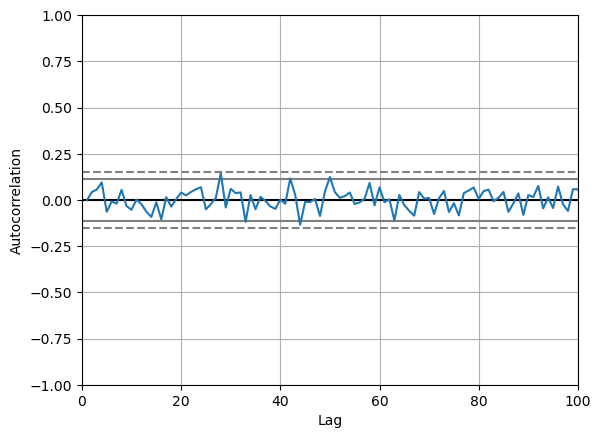

In [43]:
autocorrelation_plot(data_train).set_xlim([0,100])

Line off at autocorrelation plot is out from Threshold levels is 44th lag.

Conclusion :
p,d,q = 44,0,44

## Find AIC for ARIMA Model Predictions

In [44]:
model1 = ARIMA(data_train, order =(1,0,1))
model2 = ARIMA(data_train, order =(28,0,28))
model3 = ARIMA(data_train, order =(44,0,44))

In [45]:
model1 = model1.fit()
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                    qty   No. Observations:                  292
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1240.652
Date:                Mon, 23 Oct 2023   AIC                           2489.304
Time:                        06:09:51   BIC                           2504.011
Sample:                    01-01-2022   HQIC                          2495.195
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.1721      1.057     47.455      0.000      48.100      52.244
ar.L1         -0.8805      0.351     -2.509      0.012      -1.568      -0.193
ma.L1          0.8584      0.380      2.259      0.0

In [46]:
model2 = model2.fit()
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                    qty   No. Observations:                  292
Model:               ARIMA(28, 0, 28)   Log Likelihood               -1207.646
Date:                Mon, 23 Oct 2023   AIC                           2531.291
Time:                        06:10:25   BIC                           2744.543
Sample:                    01-01-2022   HQIC                          2616.711
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2244      2.300     21.835      0.000      45.716      54.733
ar.L1          0.1739      0.402      0.432      0.666      -0.615       0.963
ar.L2          0.3167      0.358      0.885      0.3

In [47]:
model3 = model3.fit()
print(model3.summary())

                               SARIMAX Results                                
Dep. Variable:                    qty   No. Observations:                  292
Model:               ARIMA(44, 0, 44)   Log Likelihood               -1189.831
Date:                Mon, 23 Oct 2023   AIC                           2559.662
Time:                        06:13:01   BIC                           2890.570
Sample:                    01-01-2022   HQIC                          2692.211
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         50.2068      1.423     35.290      0.000      47.418      52.995
ar.L1          0.0775      0.843      0.092      0.927      -1.575       1.729
ar.L2          0.2160      0.924      0.234      0.8

model1 for (1,0,1) --> AIC = 2489.304  
model2 for (28,0,28) --> AIC = 2531.291  
model3 for (44,0,44) --> AIC = 2559.662

### ARIMA Modelling

In [48]:
#Confidence Interval pada Data Test pada Model 1
split_size = round(df_regression.shape[0]*0.8)
data_train = df_regression[:split_size]
data_test = df_regression[split_size:]

data_train = data_train.set_index('date')
data_test = data_test.set_index('date')

forecast1 = model1.get_forecast(steps = len(data_test))
df_forecast1 = forecast1.conf_int()
print(df_forecast1.index[0])
print(df_forecast1.index[-1])

2022-10-20 00:00:00
2022-12-31 00:00:00


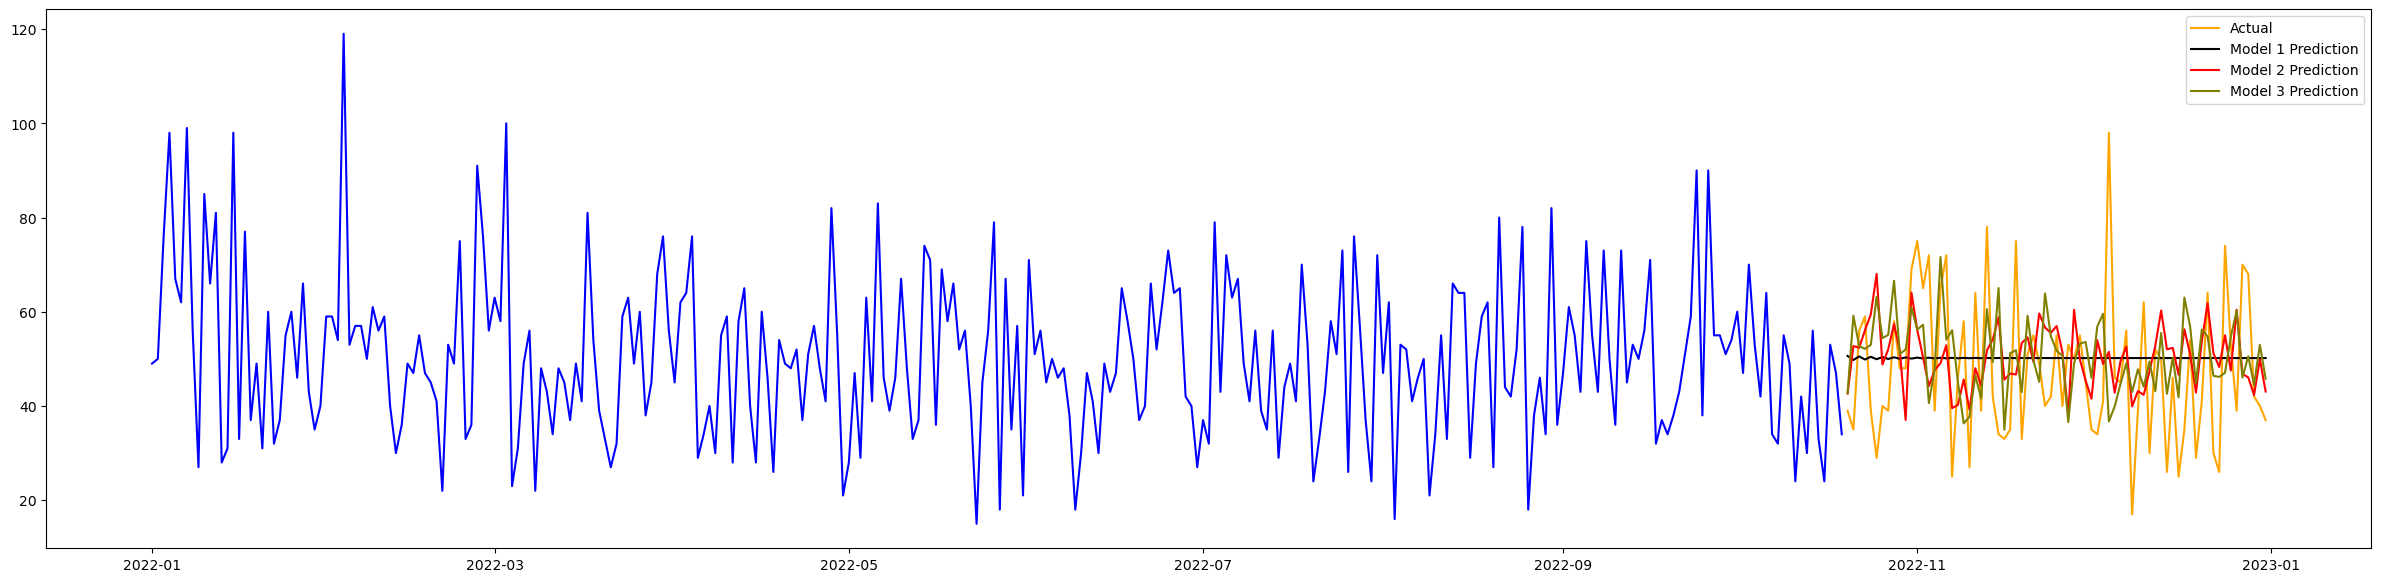

In [68]:
# Data train & Data test forecast
forecast1 = model1.get_forecast(steps = len(data_test))
forecast2 = model2.get_forecast(steps = len(data_test))
forecast3 = model3.get_forecast(steps = len(data_test))

df_forecast1 = forecast1.conf_int()
df_forecast1['Predictions'] = model1.predict(start=df_forecast1.index[0], end=df_forecast1.index[-1])
df_forecast1_out = df_forecast1['Predictions']

df_forecast2 = forecast2.conf_int()
df_forecast2['Predictions'] = model2.predict(start=df_forecast2.index[0], end=df_forecast2.index[-1])
df_forecast2_out = df_forecast2['Predictions']

df_forecast3 = forecast3.conf_int()
df_forecast3['Predictions'] = model3.predict(start=df_forecast3.index[0], end=df_forecast3.index[-1])
df_forecast3_out = df_forecast3['Predictions']

#plot forecasting
plt.figure(figsize=(30,7))
plt.plot(data_train['qty'], color='blue')
plt.plot(data_test['qty'], label = 'Actual', color ='orange')
plt.plot(df_forecast1_out, label = 'Model 1 Prediction', color ='black')
plt.plot(df_forecast2_out, label = 'Model 2 Prediction', color ='red')
plt.plot(df_forecast3_out, label = 'Model 3 Prediction', color ='olive')
plt.legend()

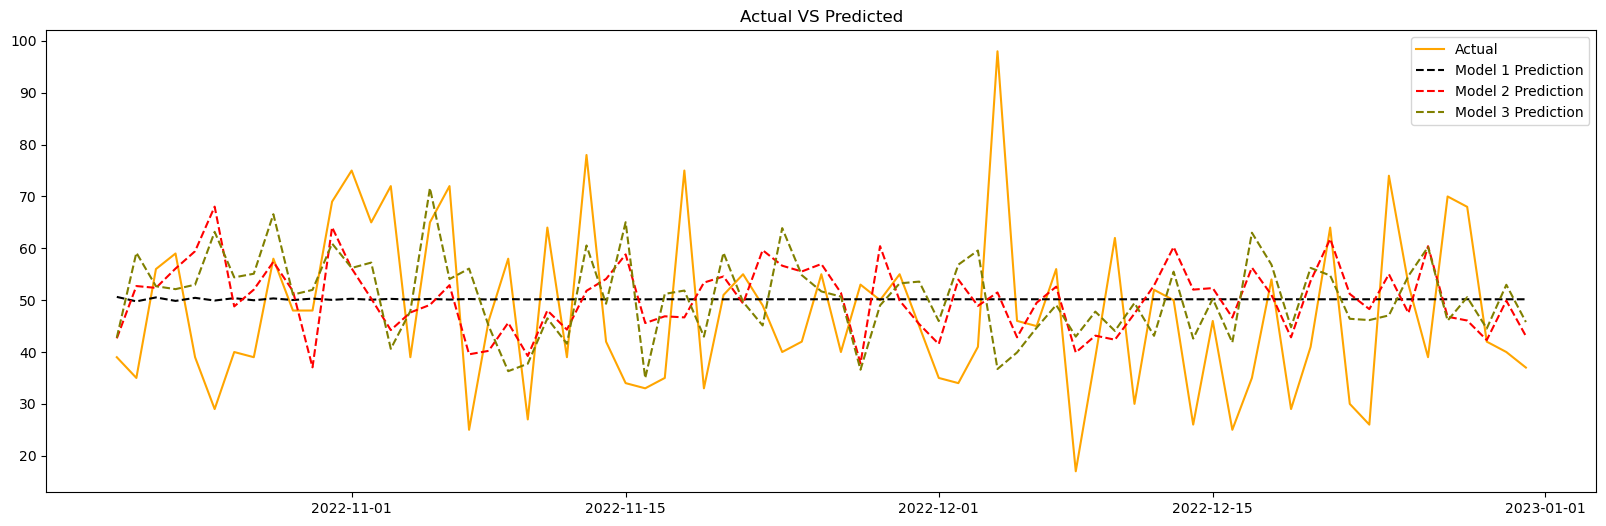

In [69]:
#Actual vs Predicted
plt.figure(figsize=(20,6))
plt.plot(data_test.index, data_test['qty'], label='Actual', color='orange')
plt.plot(data_test.index, df_forecast1_out, label = 'Model 1 Prediction', color ='black', linestyle='--')
plt.plot(data_test.index, df_forecast2_out, label = 'Model 2 Prediction', color ='red', linestyle='--')
plt.plot(data_test.index, df_forecast3_out, label = 'Model 3 Prediction', color ='olive', linestyle='--')
plt.legend()
plt.title('Actual VS Predicted')
plt.show()

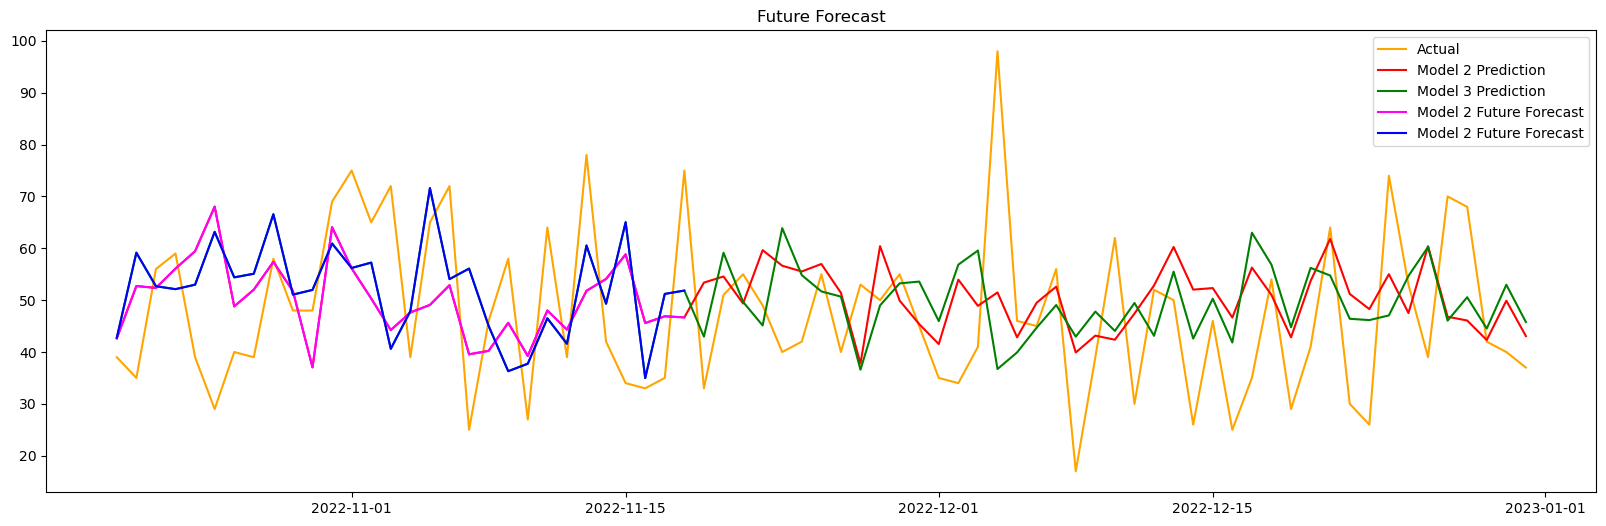

In [87]:
#Future Forecast
forecast_period = 30

future_model2 = model2.get_forecast(steps=forecast_period)
df_future_model2 =future_model2.conf_int()
df_future_model2['Predictions'] = future_model2.predicted_mean
df_future_model2.index = pd.date_range(start = data_train.index[-1], periods = forecast_period + 1, closed = 'right')
df_future_model2_out = df_future_model2['Predictions']

future_model3 = model3.get_forecast(steps=forecast_period)
df_future_model3 =future_model3.conf_int()
df_future_model3['Predictions'] = future_model3.predicted_mean
df_future_model3.index = pd.date_range(start = data_train.index[-1], periods = forecast_period + 1, closed = 'right')
df_future_model3_out = df_future_model3['Predictions']

#plot forecast
plt.figure(figsize=(20,6))
plt.plot(data_test['qty'], label='Actual', color = 'orange')
plt.plot(df_forecast2_out, label = 'Model 2 Prediction', color ='red')
plt.plot(df_forecast3_out, label = 'Model 3 Prediction', color ='green')
plt.plot(df_future_model2_out, label = 'Model 2 Future Forecast', color = 'magenta')
plt.plot(df_future_model3_out, label = 'Model 2 Future Forecast', color = 'blue')
plt.legend()
plt.title('Future Forecast')
plt.show()     

In [88]:
#MAE, MSE, RMSE, MAPE
mae1 = mean_absolute_error(data_test,df_forecast1_out)
mse1 = mean_squared_error(data_test,df_forecast1_out)
rmse1 = np.sqrt(mse1)
mape1 = mean_absolute_percentage_error(data_test,df_forecast1_out)*100

mae2 = mean_absolute_error(data_test,df_forecast2_out)
mse2 = mean_squared_error(data_test,df_forecast2_out)
rmse2 = np.sqrt(mse2)
mape2 = mean_absolute_percentage_error(data_test,df_forecast2_out)*100

mae3 = mean_absolute_error(data_test,df_forecast3_out)
mse3 = mean_squared_error(data_test,df_forecast3_out)
rmse3 = np.sqrt(mse3)
mape3 = mean_absolute_percentage_error(data_test,df_forecast3_out)*100

print("Model 1")
print(f"Mean Absolute Error (MAE) = {mae1:.2f}")
print(f"Mean Squared Error (MSE) = {mse1:.2f}")
print(f"Root Mean Squared Error (RMSE) = {rmse1:.2f}")
print(f"Mean Absolute Percentage Error (MAPE) = {mape1:.2f}%")

print("\nModel 2")
print(f"Mean Absolute Error (MAE) = {mae2:.2f}")
print(f"Mean Squared Error (MSE) = {mse2:.2f}")
print(f"Root Mean Squared Error (RMSE) = {rmse2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE) = {mape2:.2f}%")

print("\nModel 3")
print(f"Mean Absolute Error (MAE) = {mae3:.2f}")
print(f"Mean Squared Error (MSE) = {mse3:.2f}")
print(f"Root Mean Squared Error (RMSE) = {rmse3:.2f}")
print(f"Mean Absolute Percentage Error (MAPE) = {mape3:.2f}%")

Model 1
Mean Absolute Error (MAE) = 13.01
Mean Squared Error (MSE) = 246.15
Root Mean Squared Error (RMSE) = 15.69
Mean Absolute Percentage Error (MAPE) = 32.45%

Model 2
Mean Absolute Error (MAE) = 13.10
Mean Squared Error (MSE) = 255.45
Root Mean Squared Error (RMSE) = 15.98
Mean Absolute Percentage Error (MAPE) = 31.88%

Model 3
Mean Absolute Error (MAE) = 13.61
Mean Squared Error (MSE) = 290.53
Root Mean Squared Error (RMSE) = 17.04
Mean Absolute Percentage Error (MAPE) = 33.02%


Catatan :  
**Mean Absolute Error(MAE)**  
- MAE = menghitung rata-rata dari selisih absolut antara nilai prediksi dan nilai aktual.
- MAE menghitung berapa rata-rata kesalahan absolut dalam prediksi. 
- Semakin kecil nilai MAE, semakin baik kualitas model tersebut

**Mean Squared Error(MSE)**  
- MSE = menghitung rata-rata dari selisih kuadrat antara nilai prediksi dan nilai aktual.
- MSE menghitung berapa rata-rata kesalahan kuadrat dalam prediksi. 
- Semakin kecil nilai MSE, semakin baik kualitas model tersebut  

**Root Mean Squared Error(RMSE)**  
- RMSE = RMSE adalah turunan dari MSE & merupakan akar kuadrat dari MSE
- Semakin kecil nilai RMSE, semakin baik kualitas model tersebut  

**Mean Absolute Percentage Error(MAPE)**  
- MAPE = menghitung rata-rata dari selisih persentase antara nilai prediksi dan nilai aktual
- MAPE menghitung berapa rata-rata kesalahan dalam prediksi sebagai persentase dari nilai aktual
- Semakin kecil nilai MAPE, semakin baik kualitas model tersebut

Conclusion :  
Model 2 with p,d,q (28,0,28) shows the best evaluation metrics  
because even though Model 1 got the smallest for MAE, MSE, RMSE, and MAPE.  
But model 1 shows only flat line because its p,d,q (1,0,1), so we chose the best model is Model 2. 

### Forecast Quantity Sales with The Best Parameter

In [89]:
df_future_model2_out.describe()

count    30.000000
mean     50.116869
std       7.303344
min      37.041028
25%      45.600319
50%      49.702099
75%      53.784914
max      68.038147
Name: Predictions, dtype: float64

The predictions for quantity in January 2023 is 50 pcs/day

## Clustering

In [93]:
df_merge.head()

,customerid,age,gender,marital_status,income,transactionid,date,productid,price,qty,totalamount,storeid,storename,groupstore,type,product_name
0,183,27,1,Single,0.18,TR1984,2022-01-01,P1,8800,4,35200,4,Gita Ginara,Gita,General Trade,Choco Bar
1,49,44,1,Married,13.48,TR67455,2022-01-01,P5,4200,3,12600,13,Buana,Buana,General Trade,Thai Tea
2,233,43,1,Married,5.69,TR97336,2022-01-01,P7,9400,2,18800,12,Prestasi Utama,Prestasi,General Trade,Coffee Candy
3,287,36,0,Single,3.70,TR76340,2022-01-01,P4,12000,4,48000,12,Prestasi Utama,Prestasi,General Trade,Potato Chip
4,123,34,0,Married,4.36,TR99839,2022-01-01,P2,3200,6,19200,1,Prima Tendean,Prima,Modern Trade,Ginger Candy


In [98]:
preclust = df_merge.groupby('customerid').agg({'transactionid':'count', 'qty':'sum', 'totalamount':'sum'}).reset_index()
preclust.head()

,customerid,transactionid,qty,totalamount
0,1,17,60,623300
1,2,13,57,392300
2,3,15,56,446200
3,4,10,46,302500
4,5,7,27,268600


In [99]:
clust = preclust.drop(columns = 'customerid')
clust.head()

,transactionid,qty,totalamount
0,17,60,623300
1,13,57,392300
2,15,56,446200
3,10,46,302500
4,7,27,268600


In [103]:
#Standarisasi dataset
from sklearn.preprocessing import MinMaxScaler, StandardScaler
x = clust.values
x_std = StandardScaler().fit_transform(x)
df_std=pd.DataFrame(data=x_std, columns=clust.columns)
df_std.isna().sum()

transactionid    0
qty              0
totalamount      0
dtype: int64

In [104]:
#Normalisasi dataset dengan MinMaxScaler
x_norm = MinMaxScaler().fit_transform(x)
x_norm

array([[0.77777778, 0.72463768, 0.70394911],
       [0.55555556, 0.68115942, 0.39782666],
       [0.66666667, 0.66666667, 0.46925523],
       ...,
       [0.83333333, 0.84057971, 0.6561092 ],
       [0.44444444, 0.46376812, 0.43890803],
       [0.55555556, 0.46376812, 0.46011132]])

In [106]:
#Normalisasi dataset dengan Preprocessing sklearns
x_norm2 = preprocessing.normalize(clust)
x_norm2

array([[2.72741856e-05, 9.62618317e-05, 9.99999995e-01],
       [3.31379043e-05, 1.45296965e-04, 9.99999989e-01],
       [3.36172117e-05, 1.25504257e-04, 9.99999992e-01],
       ...,
       [3.06539507e-05, 1.15803814e-04, 9.99999993e-01],
       [2.59862980e-05, 9.92204105e-05, 9.99999995e-01],
       [2.95925334e-05, 9.56066465e-05, 9.99999995e-01]])

In [107]:
x_std

array([[ 1.78828224,  1.50893374,  2.10242393],
       [ 0.55344971,  1.27289149,  0.24634281],
       [ 1.17086598,  1.19421074,  0.67942841],
       ...,
       [ 2.09699037,  2.13837973,  1.81236104],
       [-0.06396655,  0.09268025,  0.49542729],
       [ 0.55344971,  0.09268025,  0.62398702]])

In [109]:
#Convert standarisasi data ke Data frame
df_std

,transactionid,qty,totalamount
0,1.788282,1.508934,2.102424
1,0.553450,1.272891,0.246343
2,1.170866,1.194211,0.679428
3,-0.372675,0.407403,-0.475199
4,-1.298799,-1.087531,-0.747585
...,...,...,...
439,0.553450,-0.300723,-0.741157
440,2.096990,1.666295,1.736029
441,2.096990,2.138380,1.812361
442,-0.063967,0.092680,0.495427


In [121]:
#wcss values
wcss=[]
for n in range (1,11):
    model1= KMeans(n_clusters=n, max_iter=100, random_state=100)
    model1.fit(x_std)
    wcss.append(model1.inertia_)
print(wcss)

[1332.0000000000005, 543.4711248616253, 316.5534498820666, 237.6926072959066, 191.1195660230915, 169.35451312292085, 153.47776505365613, 141.05061635433518, 130.30720488758973, 121.28772073867489]


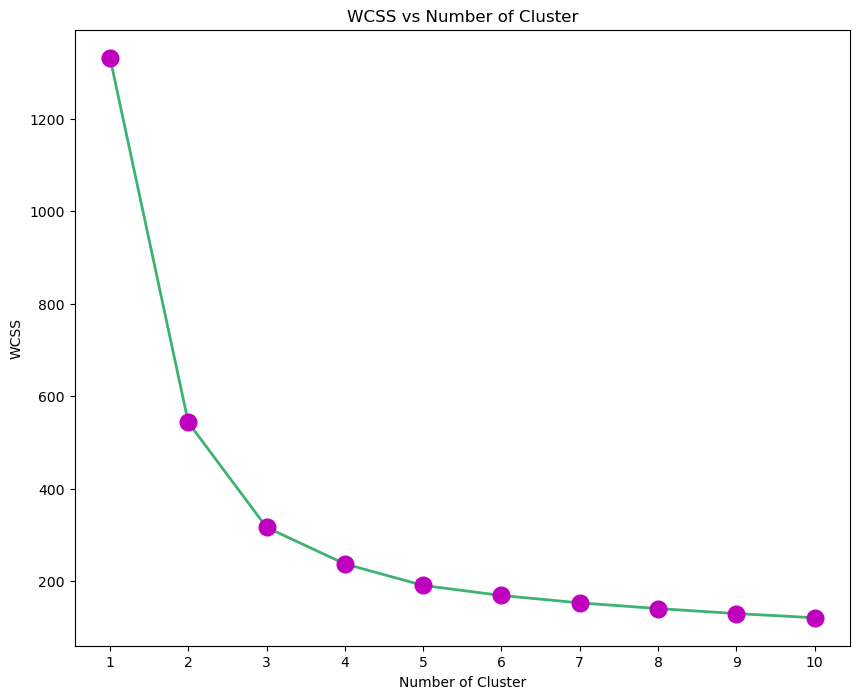

In [122]:
#plot WCSS vs Number of Cluster
plt.figure(figsize=(10,8))
plt.plot(list(range(1,11)), wcss, color='mediumseagreen', marker='o', linewidth=2, markersize=12, markerfacecolor = 'm', markeredgecolor ='m')
plt.title('WCSS vs Number of Cluster')
plt.xlabel('Number of Cluster')
plt.ylabel('WCSS')
plt.xticks(list(range(1,11)))
plt.show()

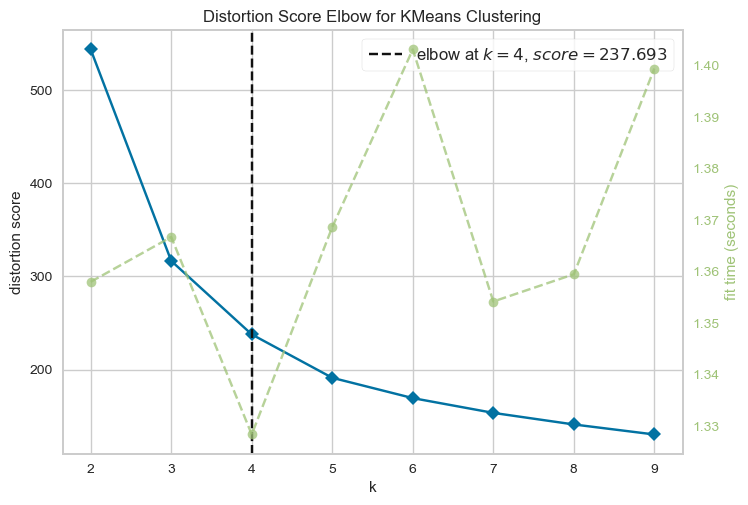

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [123]:
#Elbow method with yellowbrick
from yellowbrick.cluster import KElbowVisualizer
visualizer = KElbowVisualizer(model1, k=(2,10))
visualizer.fit(x_std)
visualizer.show()

In [136]:
# The best KMeans clustering is when k=4
kmeans_4 = KMeans(n_clusters=4, max_iter=100, n_init=10, random_state=100)
kmeans_4.fit(x_std)

KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=100)

In [137]:
#Input cluster to dataset

clust['cluster']=kmeans_4.labels_
clust.head()

,transactionid,qty,totalamount,cluster
0,17,60,623300,2
1,13,57,392300,3
2,15,56,446200,3
3,10,46,302500,0
4,7,27,268600,1


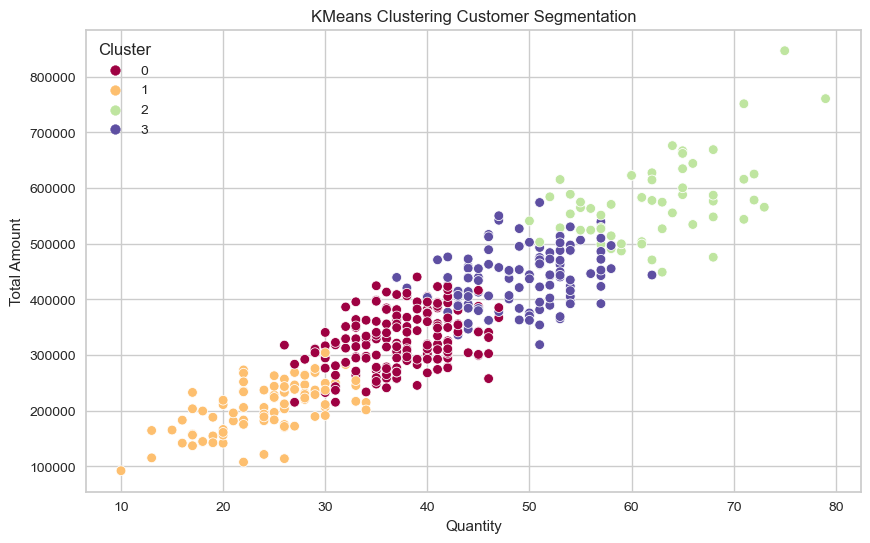

In [149]:
#convert 'cluster' column to categorical data type
clust['customerID']=preclust['customerid'].astype('category')

#create scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=clust ,x='qty',y='totalamount', hue='cluster', palette='Spectral', sizes=70)
plt.xlabel('Quantity')
plt.ylabel('Total Amount')
plt.title('KMeans Clustering Customer Segmentation')
plt.legend(title='Cluster')
plt.show()

In [151]:
#input customerID to dataset
clust['customerID']=preclust['customerid']
cluster_mean=clust.groupby('cluster').agg({'customerID':'count', 'qty':'mean', 'totalamount':'mean'})
cluster_mean.sort_values('customerID', ascending=False)

,customerID,qty,totalamount
cluster,,,
0,180,37.350000,325663.333333
3,115,49.121739,437241.739130
1,93,24.505376,208283.870968
2,56,62.035714,576716.071429


Conclusion:
Based on KMeans clustering for 4 cluster segmentation, we conclude that:  
**Cluster 1**   
*Insight :*
- Cluster 1 is the cluster with the second fewest number of customers
- Cluster 1 has the lowest average of quantity and total amount  
  
*Conclusion :* Cluster 1 is customer that need to give more brand awareness  

*Strategy :*
1. Give special offering and discount for new member  
2. Engage current customers to help attract new customers with referral codes 
3. Collaborate with influencers to promote products  
  
  
**Cluster 0**   
*Insight :*
- Cluster 0 is the cluster with the most largest number of customers
- Cluster 0 has the second lowest average of quantity and total amount  
  
*Conclusion :* Cluster 0 needs to get promotion  

*Strategy :*
1. Give special offering and discount 
2. Offer bundling product  
    
    
**Cluster 3**   
*Insight :*
- Cluster 3 is the cluster with the second largest number of customers
- Cluster 3 has the second largest average of quantity and total amount  
  
*Conclusion :* Cluster 3 is the customer that has potential of upselling  

*Strategy :*
1. Offer bundling product 
2. Offer loyalty membership 
    
    
**Cluster 2**   
*Insight :*
- Cluster 2 is the cluster with the smallest number of customers
- Cluster 2 has the largest average of quantity and total amount  
  
*Conclusion :* Cluster 2 is the customer that valuable to the business 

*Strategy :*
1. Offer bundling product 
2. Offer loyalty membership